# Homework 4

### 1a) Examine cloud and binned semi-variograms and comment on the evidence for spatial dependence  

In [2]:
# load in the source data
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
library(geoR)
library(sp)
library(rgdal)
library(maptools)
library(splancs)
library(spatstat)
library(lattice)
library(SpatialEpi)
library(sp)
library(Matrix)
library(splines)
library(RColorBrewer)
library(maps)
library(maptools)
library(classInt)
library(ggplot2)
library(foreign)
library(mgcv)
data("ca20")

variog: computing omnidirectional variogram


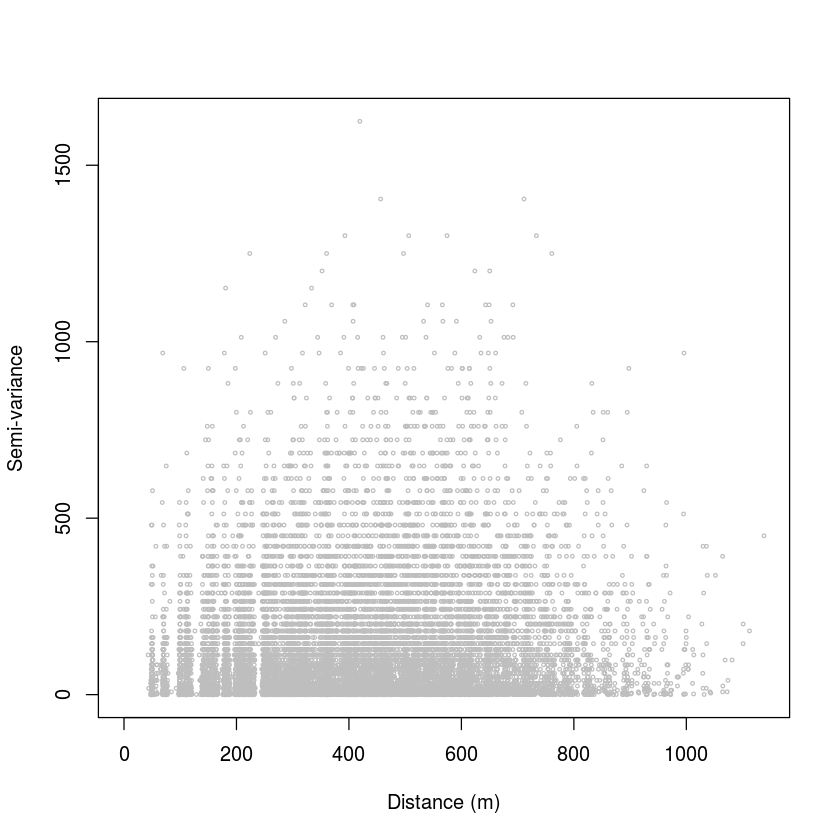

In [3]:
cloudca20 <- variog(ca20, option = "cloud")
plot(cloudca20, ylab = "Semi-variance", xlab = "Distance (m)",
     col = "grey", cex = 0.4)

variog: computing omnidirectional variogram


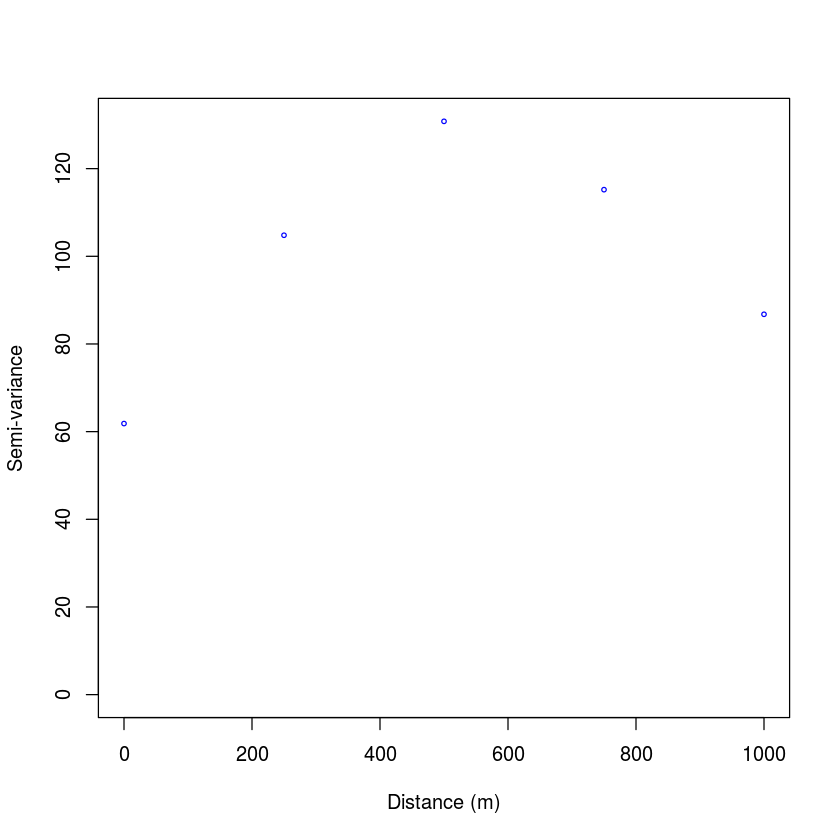

In [4]:
binca20 <- variog(ca20, uvec = seq(0,5000, 250), 
                  trend = ~ca20$covariate$altitude)
plot(binca20, ylab = "Semi-variance", xlab = "Distance (m)",
     cex = 0.5, col = "blue")

Looking at the binned variogram at distances between 0 and 600 meters there appears to be some level of spatial dependence.

### 1b) Using the semi-variogram examine Monte Carlo intervals for no spatial dependence

variog.env: generating 99 simulations by permutating data values
variog.env: computing the empirical variogram for the 99 simulations
variog.env: computing the envelops


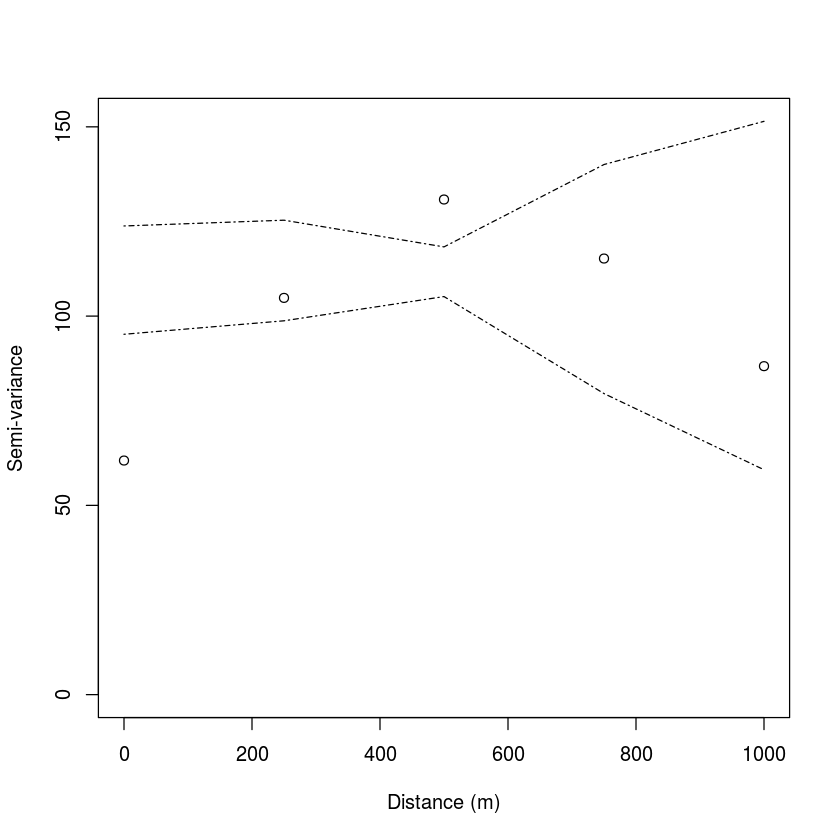

In [5]:
ca20.env <- variog.mc.env(ca20, obj = binca20)
plot(binca20, env = ca20.env, xlab = "Distance (m)",ylab = "Semi-variance")

The observed data greatly strays away from the expected values of variance that you would  
see under no spatial dependence.

### 1c) Fit an exponential variogram model to these data, using least squares, maximum likelihood and restricted maximum likelihood.

In [6]:
olsfit <- variofit(binca20, ini = c(50, 50), weights = "equal")
olsfit

variofit: covariance model used is matern 
variofit: weights used: equal 
variofit: minimisation function used: optim 


variofit: model parameters estimated by OLS (ordinary least squares):
covariance model is: matern with fixed kappa = 0.5 (exponential)
parameter estimates:
  tausq sigmasq     phi 
61.7763 48.4090 88.4765 
Practical Range with cor=0.05 for asymptotic range: 265.052

variofit: minimised sum of squares = 1011.59

In [7]:
mlfit <- likfit(ca20, ini = c(50, 50), trend = ~ca20$covariate$altitude, 
                messages=FALSE)
remlfit <- likfit(ca20, ini = c(50,50), lik.method = "RML", trend = ~ca20$covariate$altitude, 
                  messages=FALSE)
print("maximum likelihood")
mlfit$parameters.summary
print("restricted maximum likelihood")
remlfit$parameters.summary

[1] "maximum likelihood"


,status,values
beta0,estimated,39.1632
beta1,estimated,2.0209
tausq,estimated,15.997
sigmasq,estimated,128.1412
phi,estimated,147.0894
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


[1] "restricted maximum likelihood"


,status,values
beta0,estimated,40.151
beta1,estimated,1.8781
tausq,estimated,18.9967
sigmasq,estimated,149.9804
phi,estimated,191.6871
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


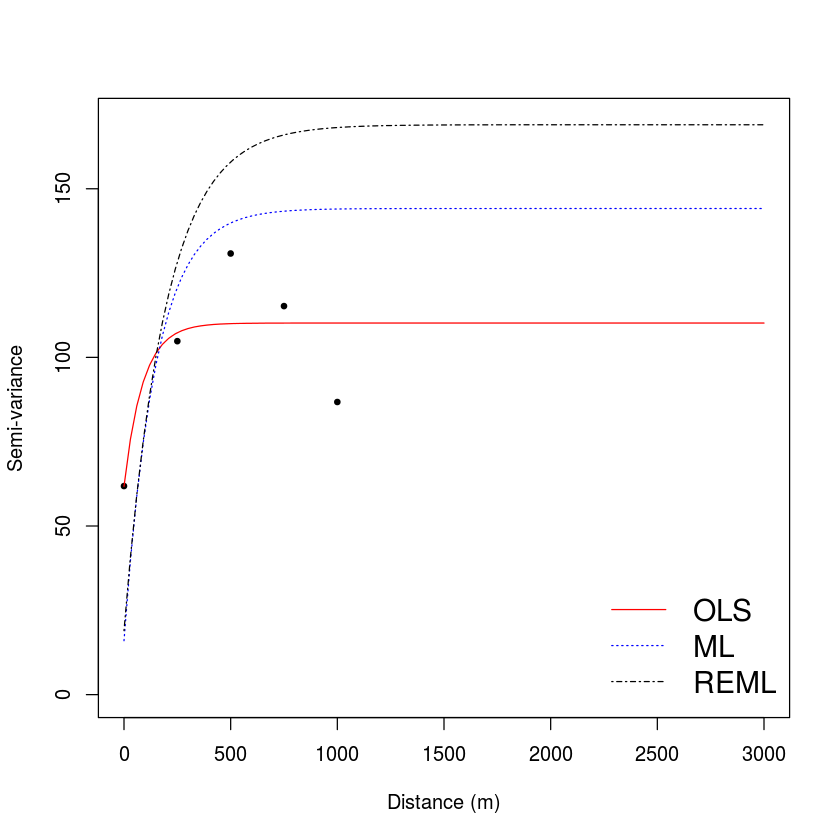

In [8]:
plot(binca20, max.dist = 3000, xlab = "Distance (m)",ylab = "Semi-variance", 
     pch = 19, cex = 0.6, ylim= c(0,170))
lines(olsfit, max.dist = 3000, col = "red")
lines(mlfit, max.dist = 3000, lty = 3, col = "blue")
lines(remlfit, max.dist = 3000, lty = 4, col = "black")
legend("bottomright", legend = c("OLS", "ML", "REML"), lty = c(1, 3, 4), bty = "n", 
       col = c("red", "blue", "black"), cex = 1.5)

### 1d) Carry  out  kriging  and  examine  the  resultant  surface, mean & SD

In [9]:
lmfit <- lm(ca20$data ~ ca20$covariate$altitude)
detrend <- as.geodata(cbind(ca20$coords, lmfit$residuals))
mlfit2 <- likfit(detrend, ini = c(50, 50), messages=FALSE)

In [10]:
pred.grid <- expand.grid(seq(4800, 6000,l = 51), seq(4800, 5800, l = 51))
kc <- krige.conv(detrend, loc = pred.grid, krige = krige.control(obj.m = mlfit2))

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


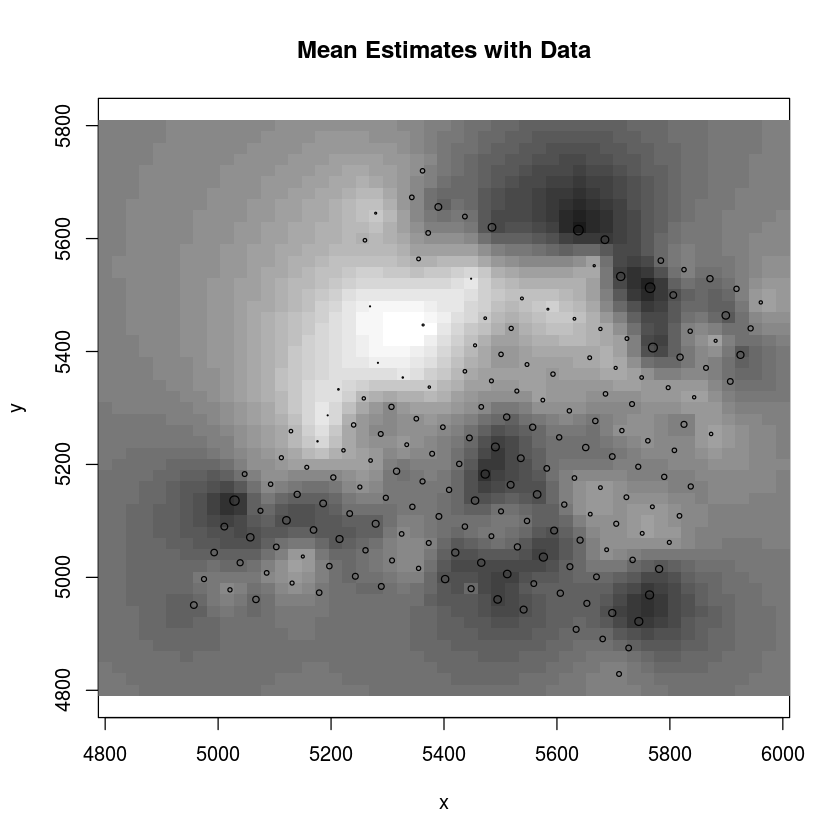

In [11]:
image(kc, loc=pred.grid, val=kc$predict, col=gray(seq(1,.1,l=30)),
      xlab="x",ylab="y", main="Mean Estimates with Data")
symbols(detrend$coords[,1], detrend$coords[,2],
        circles=(detrend$data-min(detrend$data))/1,
        add=TRUE, inches=0.04)

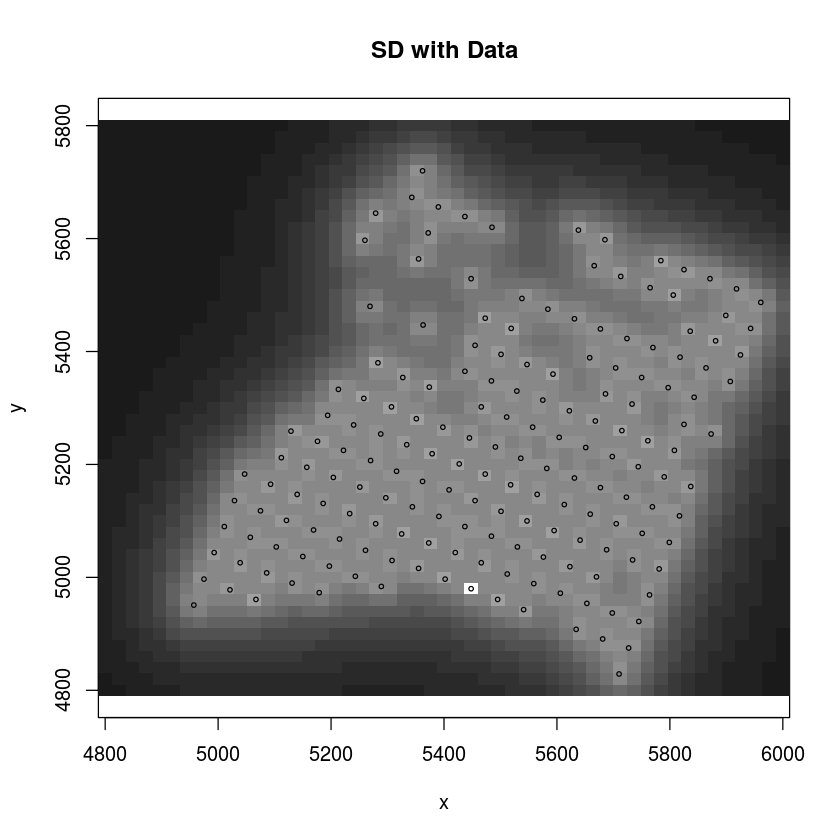

In [12]:
image(kc, val=sqrt(kc$krige.var), col=gray(seq(1,.1,l=30)), 
      xlab="x", ylab="y", main="SD with Data")
points(detrend$coords[,1], detrend$coords[,2], cex=.5)

Kriging shows us what the variogram also showed, that these data have some degree of spatial dependence. 
The mean estimates show spatial grouping of similar residuals and the standard deviation plot 
shows that as we stray away from our dat points the uncertainty in our predicted estimates grows.

### 2a) Produce point maps of the non-case and case densities using kernel density estimation

In [13]:
setwd("../hw1")
source("AlaskaScript.R", echo=FALSE)
setwd("../hw4")
alaska <- subset(x, ASTHMA != -999)

In [14]:
pointdf <- SpatialPointsDataFrame(coords=alaska[,c("X_COORD", "Y_COORD")],
                                  data=alaska[,c("MOLD","ASTHMA")])

In [19]:
bwasthma <- 20
pppasthma <- as(pointdf, "ppp")

In [20]:
#marks(pppasthma) <- relevel(pppasthma$marks$Asthma, "control")
cases <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 1))
ncases <- npoints(cases)
controls <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 0))
ncontrols <- npoints(controls)

In [21]:
kcases <- density(cases, bwasthma)
kcontrols <- density(controls, bwasthma)
spkratio0 <- as(kcases, "SpatialGridDataFrame")
names(spkratio0) <- "kcases"
spkratio0$kcontrols <- as(kcontrols, "SpatialGridDataFrame")$v
spkratio <- as(spkratio0, "SpatialPixelsDataFrame")
spkratio$kratio <- (spkratio$kcases + .00000001)/(spkratio$kcontrols + .00000001)
spkratio$krationorm <- spkratio$kratio/(ncases/ncontrols)
spkratio$logratio <-log(spkratio$kratio)-log(ncases/ncontrols)

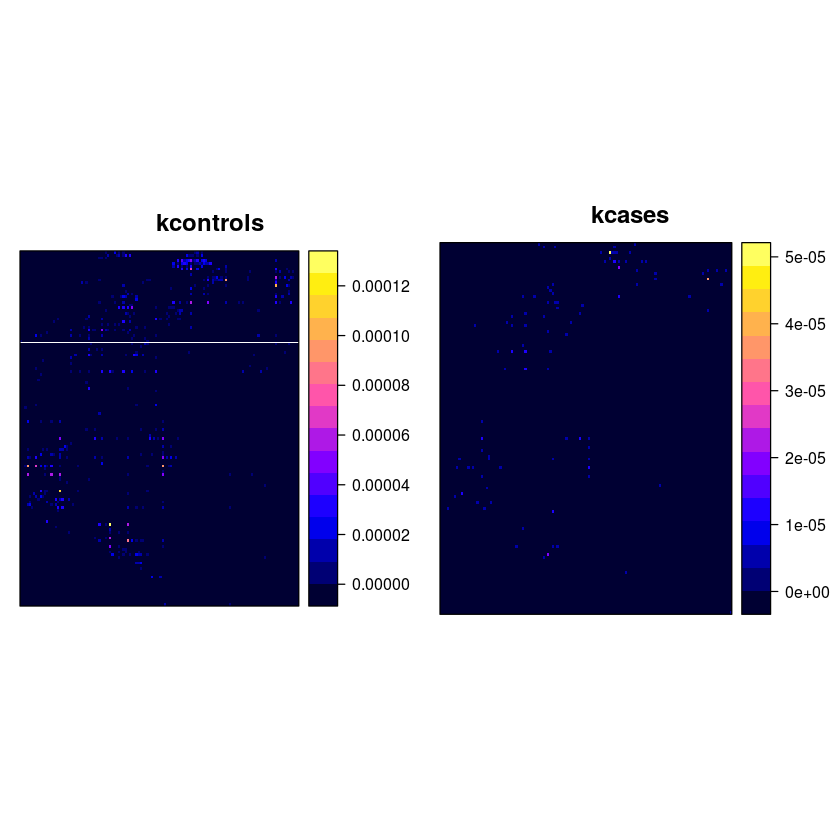

In [22]:
p1 <- spplot(spkratio, "kcontrols", main="kcontrols")
p2 <- spplot(spkratio, "kcases", main="kcases")
p3 <- spplot(spkratio, "kratio", main="kratio")

print(p1, position=c(0, 0, .5, 1), more=T)
print(p2, position=c(.5, 0, 1, 1))

### 2b) Produce a map of the log odds ratio surface using the ratio

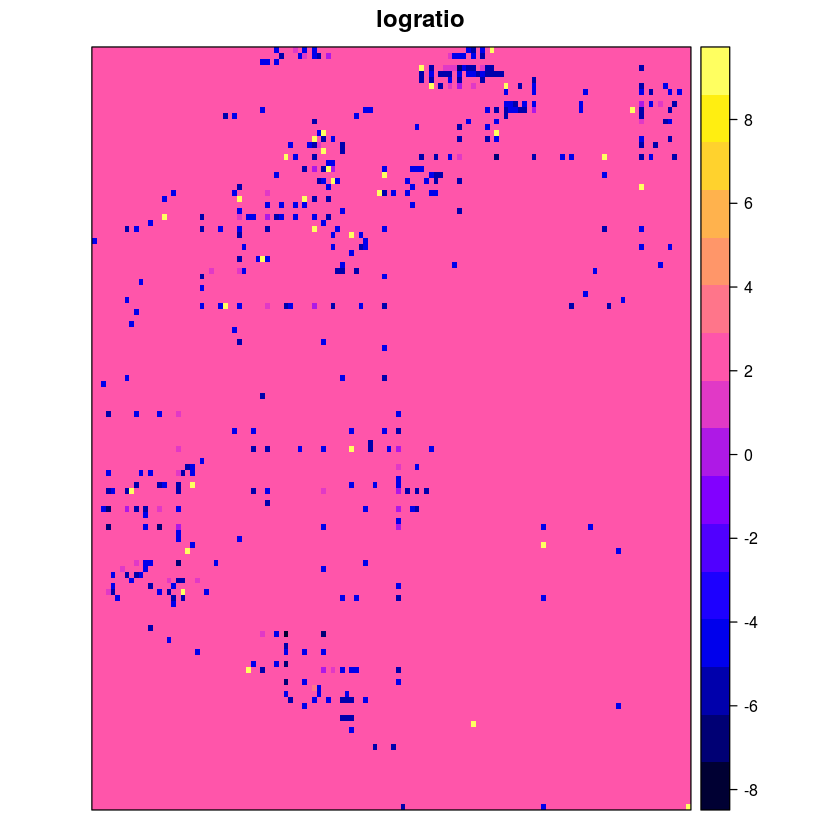

In [32]:
spplot(spkratio, "logratio", main="logratio")

### 2c) With different bandwidths do you see evidence of areas of high asthma oddsratios for these data

In [33]:
test_bandwith <- function(bwasthma, p = pointdf){
    pppasthma <- as(pointdf, "ppp")
    cases <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 1))
    ncases <- npoints(cases)
    controls <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 0))
    ncontrols <- npoints(controls)
    kcases <- density(cases, bwasthma)
    kcontrols <- density(controls, bwasthma)
    spkratio0 <- as(kcases, "SpatialGridDataFrame")
    names(spkratio0) <- "kcases"
    spkratio0$kcontrols <- as(kcontrols, "SpatialGridDataFrame")$v
    spkratio <- as(spkratio0, "SpatialPixelsDataFrame")
    spkratio$kratio <- (spkratio$kcases + .00000001)/(spkratio$kcontrols + .00000001)
    spkratio$krationorm <- spkratio$kratio/(ncases/ncontrols)
    spkratio$logratio <-log(spkratio$kratio)-log(ncases/ncontrols)
    spkratio
}

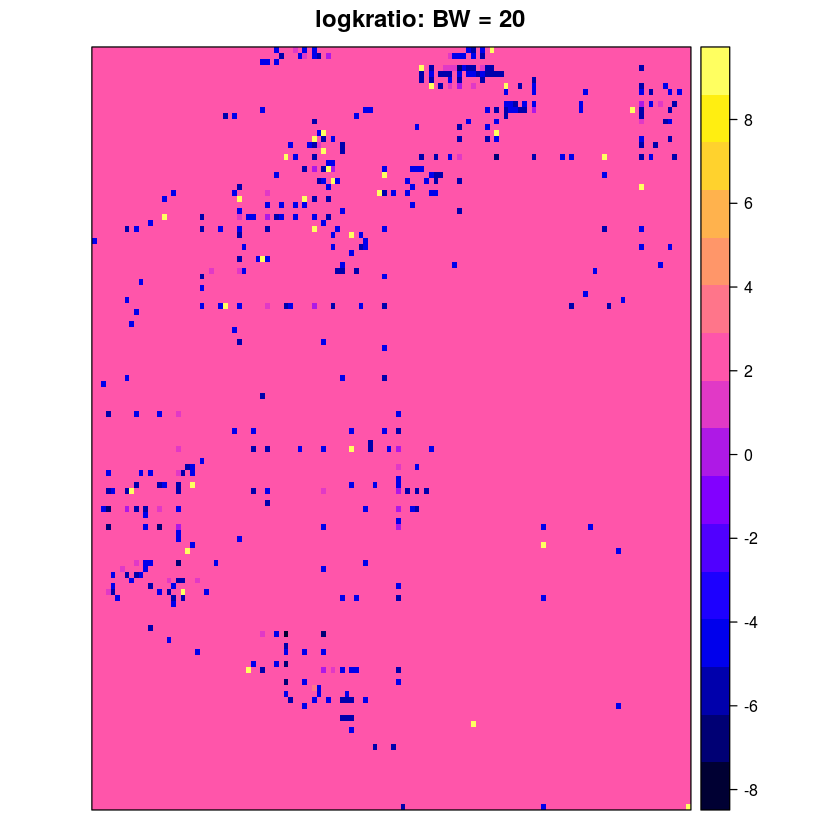

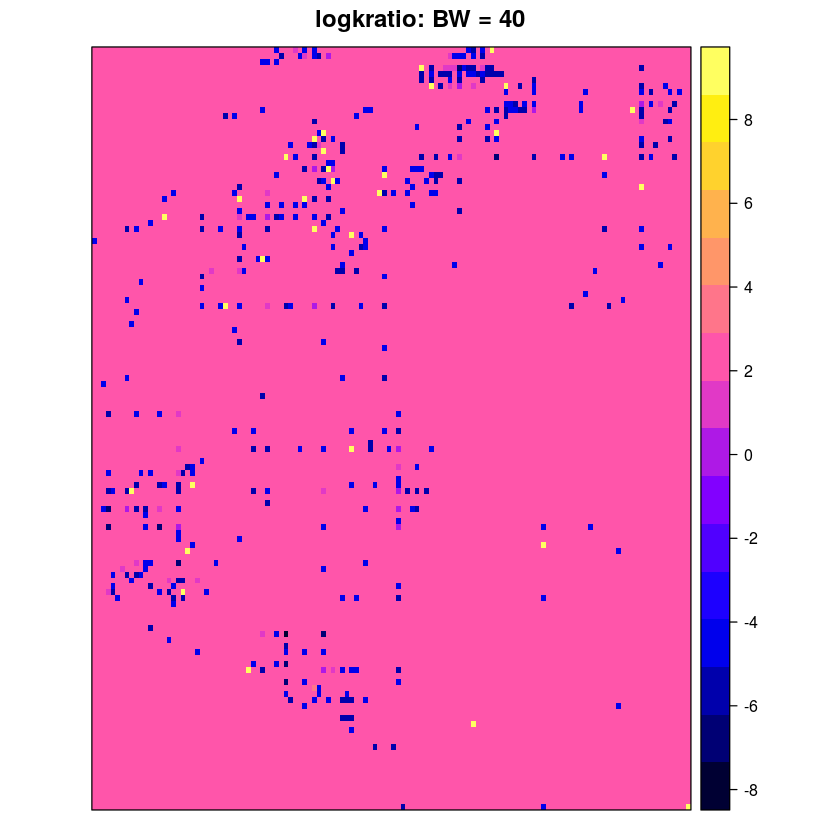

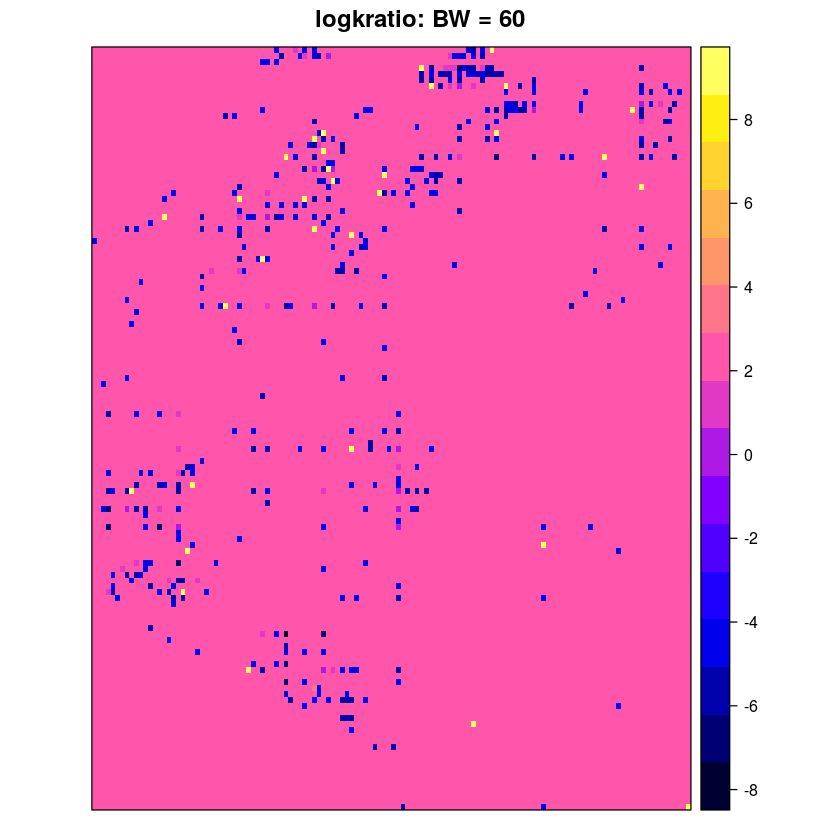

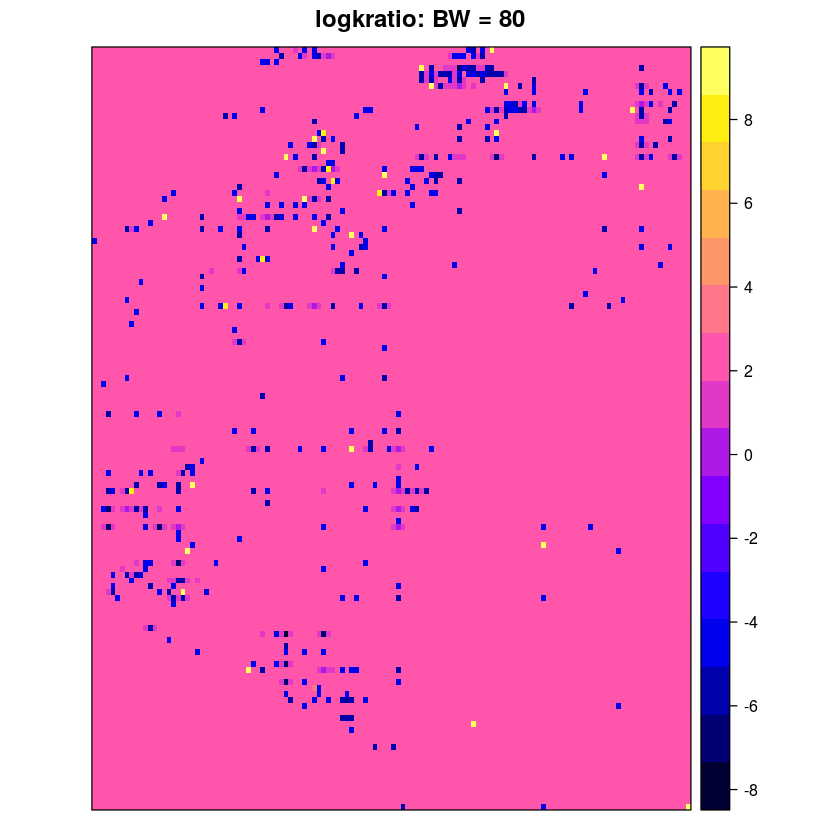

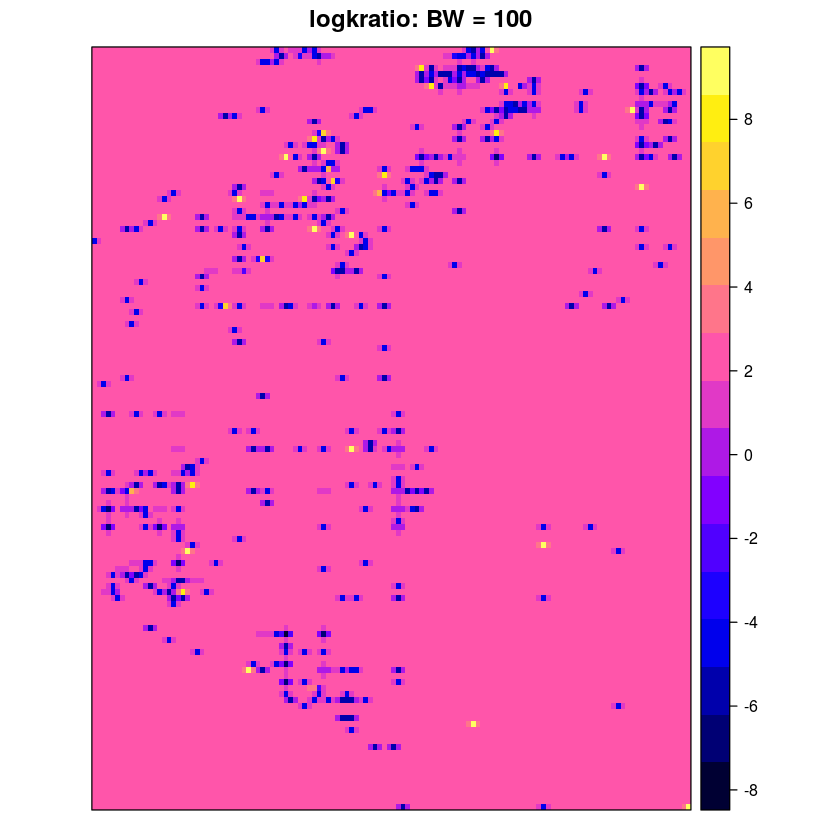

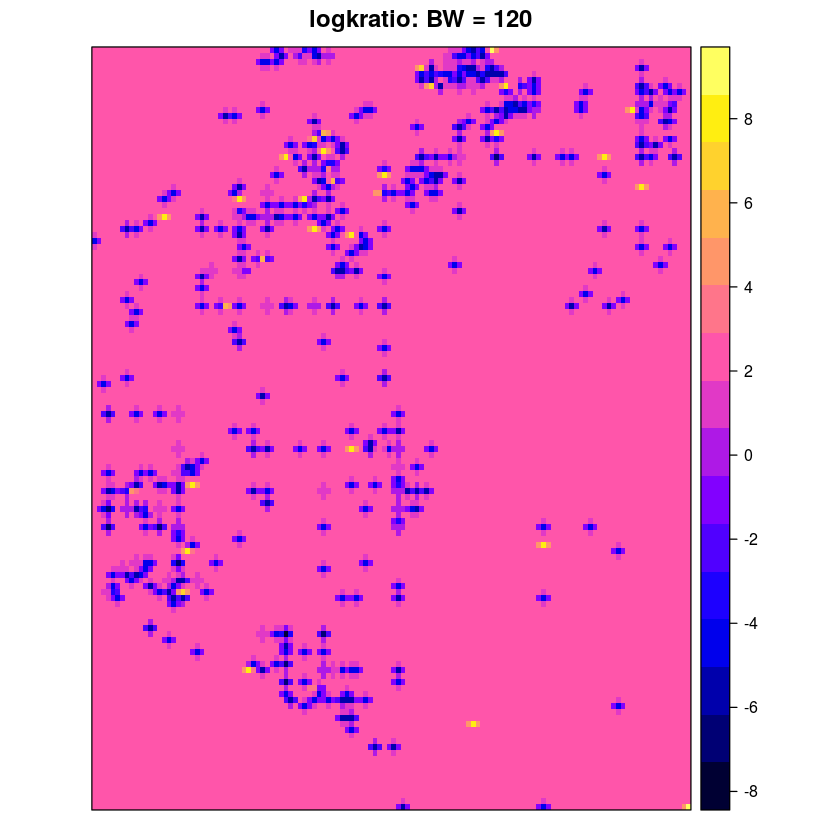

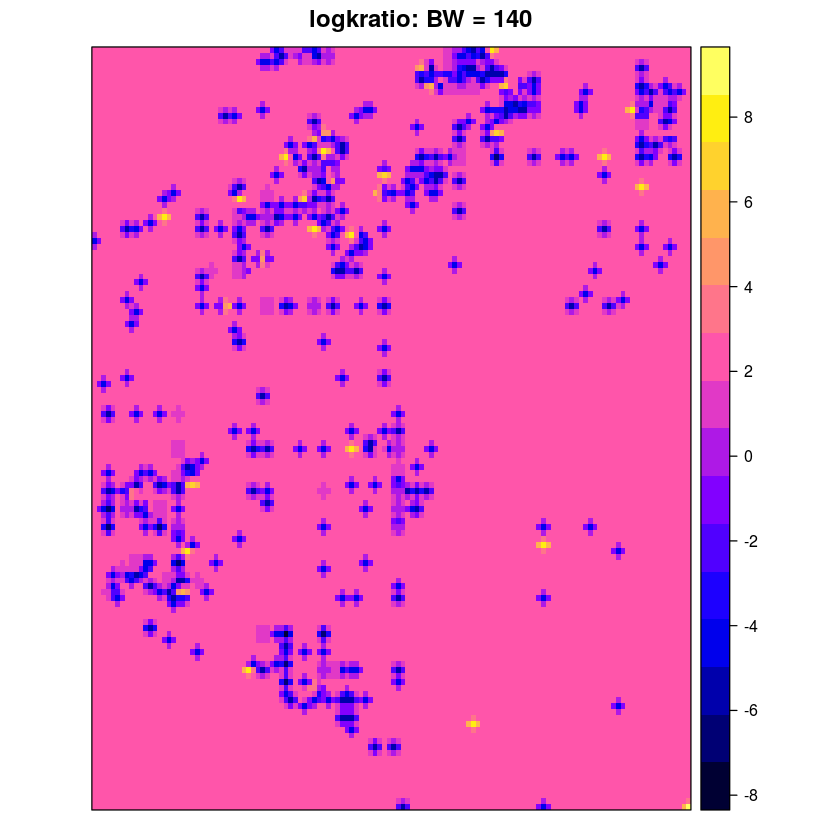

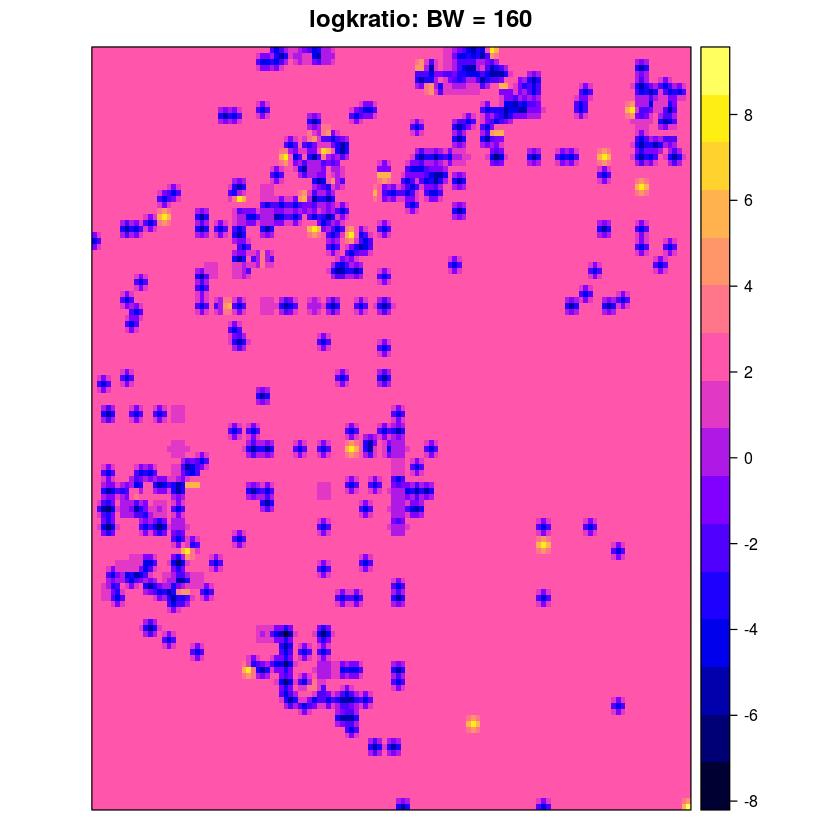

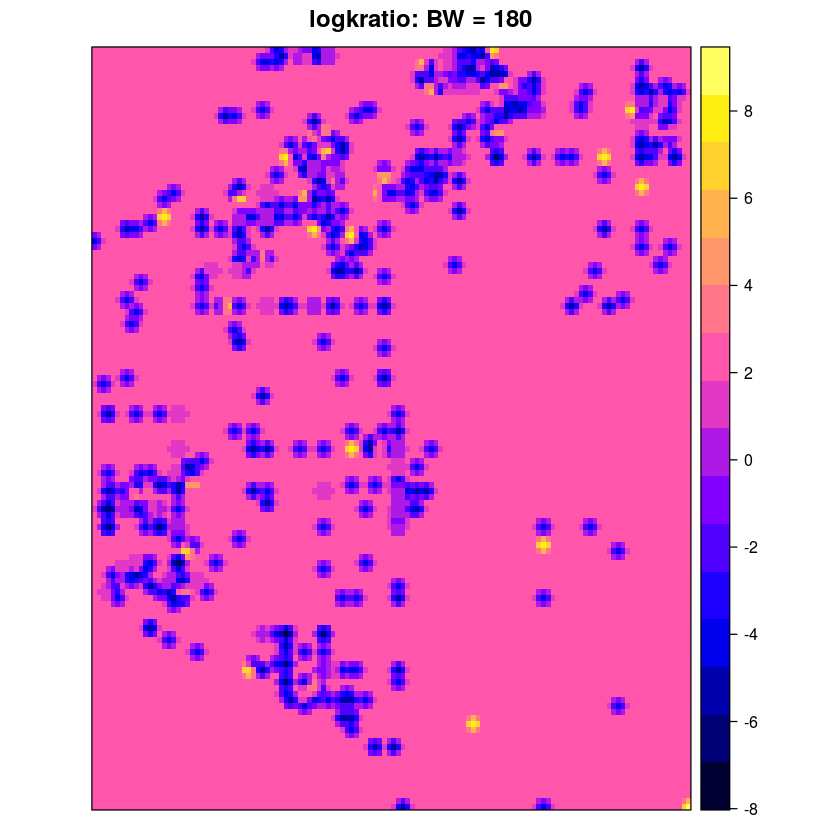

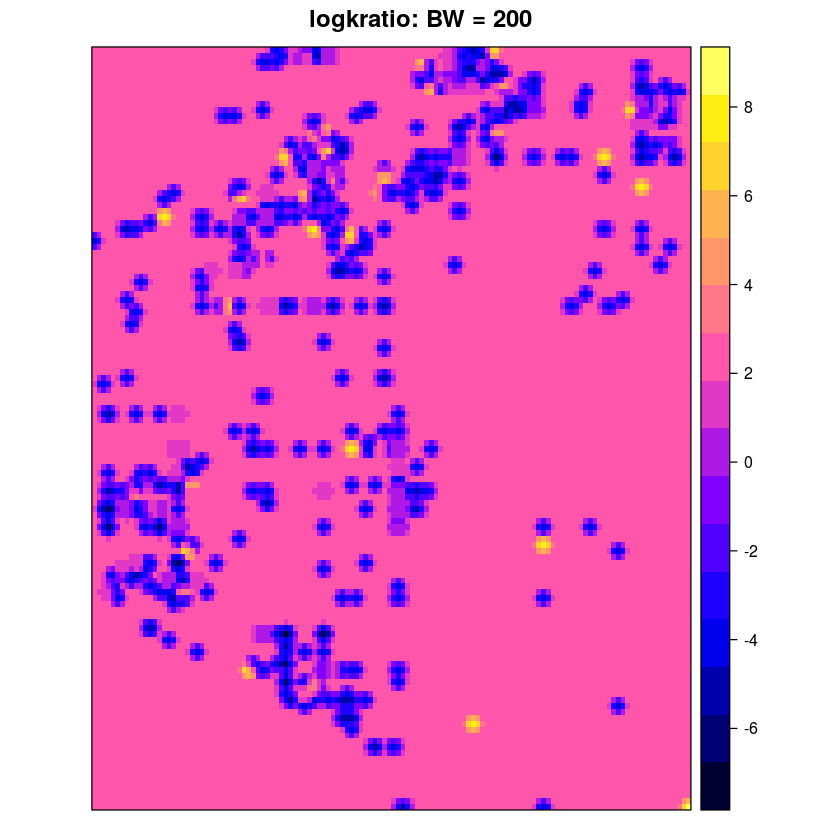

In [35]:
for (i  in (1:10 * 20)){
    spkratio_sub <- test_bandwith(bwasthma=i, p = pointdf)
    p_sub <- spplot(spkratio_sub, "logratio", main=paste0("logkratio: BW = ", i))
    print(p_sub)
}

It appears that across all selections of bandwidths there are ares of large asthma risk as shown by 
the log odds.

### 2d)  Fit a glm with exposure as a predictor

In [26]:
ccasthma <- coordinates(pointdf)
pointdf@data <- cbind(pointdf@data, ccasthma)

In [27]:
alaska$EXPOSURE <- 10*alaska[,60]/max(alaska[,60])

In [28]:
summary(glm(ASTHMA ~ EXPOSURE, data=alaska, family="binomial"))


Call:
glm(formula = ASTHMA ~ EXPOSURE, family = "binomial", data = alaska)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5901  -0.4983  -0.4751  -0.4667   2.1328  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.16576    0.13385 -16.180   <2e-16 ***
EXPOSURE     0.05060    0.04583   1.104     0.27    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 763.19  on 1085  degrees of freedom
Residual deviance: 762.01  on 1084  degrees of freedom
AIC: 766.01

Number of Fisher Scoring iterations: 4


### 2e)  Fit a glm with exposure and coordinates as a predictor

In [29]:
summary(glm(ASTHMA ~ EXPOSURE + X_COORD + Y_COORD, data=alaska, family="binomial"))


Call:
glm(formula = ASTHMA ~ EXPOSURE + X_COORD + Y_COORD, family = "binomial", 
    data = alaska)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5853  -0.5156  -0.4842  -0.4316   2.3412  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept) -3.170e+01  1.799e+01  -1.762   0.0781 .
EXPOSURE     4.523e-02  4.575e-02   0.989   0.3229  
X_COORD     -3.849e-06  1.097e-05  -0.351   0.7258  
Y_COORD      1.204e-05  7.891e-06   1.525   0.1272  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 763.19  on 1085  degrees of freedom
Residual deviance: 759.18  on 1082  degrees of freedom
AIC: 767.18

Number of Fisher Scoring iterations: 5


In [36]:
alaska$X_COORD_NORM <- (alaska$X_COORD - mean(alaska$X_COORD)) / sd(alaska$X_COORD)
alaska$Y_COORD_NORM <- (alaska$Y_COORD - mean(alaska$Y_COORD)) / sd(alaska$Y_COORD)
alaska$EXPOSURE_NORM <- (alaska$EXPOSURE - mean(alaska$EXPOSURE)) / sd(alaska$EXPOSURE)
summary(glm(ASTHMA ~ EXPOSURE_NORM + X_COORD_NORM + Y_COORD_NORM, data=alaska, family="binomial"))


Call:
glm(formula = ASTHMA ~ EXPOSURE_NORM + X_COORD_NORM + Y_COORD_NORM, 
    family = "binomial", data = alaska)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5853  -0.5156  -0.4842  -0.4316   2.3412  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.08188    0.09741 -21.372   <2e-16 ***
EXPOSURE_NORM  0.09057    0.09161   0.989    0.323    
X_COORD_NORM  -0.04146    0.11820  -0.351    0.726    
Y_COORD_NORM   0.18823    0.12342   1.525    0.127    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 763.19  on 1085  degrees of freedom
Residual deviance: 759.18  on 1082  degrees of freedom
AIC: 767.18

Number of Fisher Scoring iterations: 5


The estimate of the beta coefficent of the exposure has slightly changed. 
After normalizing the covariates it appears that there is a stronger effect from the position of the
data than the exposure both in terms of change in log odds ratio and in the signifigance. 
This shows some evidence for spatial dependence. 

### 2f) Fit a generalized additive model to these data

In [30]:
summary(gam(ASTHMA ~ EXPOSURE + s(X_COORD, Y_COORD), family=binomial, data=alaska))


Family: binomial 
Link function: logit 

Formula:
ASTHMA ~ EXPOSURE + s(X_COORD, Y_COORD)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.16646    0.13407 -16.159   <2e-16 ***
EXPOSURE     0.04523    0.04575   0.988    0.323    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df Chi.sq p-value
s(X_COORD,Y_COORD) 2.002  2.004   2.75   0.253

R-sq.(adj) =  0.00138   Deviance explained = 0.526%
UBRE = -0.29357  Scale est. = 1         n = 1086

In [37]:
summary(gam(ASTHMA ~ EXPOSURE_NORM + s(X_COORD_NORM, Y_COORD_NORM), family=binomial, data=alaska))


Family: binomial 
Link function: logit 

Formula:
ASTHMA ~ EXPOSURE_NORM + s(X_COORD_NORM, Y_COORD_NORM)

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.08188    0.09741 -21.372   <2e-16 ***
EXPOSURE_NORM  0.09055    0.09162   0.988    0.323    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                               edf Ref.df Chi.sq p-value
s(X_COORD_NORM,Y_COORD_NORM) 2.002  2.005   2.75   0.254

R-sq.(adj) =  0.00138   Deviance explained = 0.526%
UBRE = -0.29357  Scale est. = 1         n = 1086

In both the normalized and the non normalized model there is not strong 
hypothesis based evidence for spatial effects. 